In [1]:
# import libraries
import warnings
from sklearn import model_selection
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import TensorDataset, DataLoader
import math
#nltk.download()
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np
import pandas as pd
nltk.download('stopwords')
nltk.download('punkt')

import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to C:\Users\sai prasad
[nltk_data]     reddy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\sai prasad
[nltk_data]     reddy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
class Dataset:
    def __init__(self, path):
        self.df = pd.read_csv("training_data.csv")
        self.data = self.df.to_numpy()
        self.stopwords = set(stopwords.words('english'))
        self.essay_id = self.data[:,0]
        self.text = self.data[:,1]
        self.scores = self.data[:,2:8]
        self.new_data = []
        self.new_scores = []
        self.vocab = set()
        self.word_to_id = None

    def preprocess(self):
        for i in range(len(self.essay_id)):
            text = self.text[i].lower()
            text = " ".join([word for word in text.split() if '@' not in word])
            text = word_tokenize(text)
            text = [word for word in text if word not in self.stopwords]
            self.text[i] = text 

    def create_vocab(self):
        for line in self.text:
            for word in line:
                self.vocab.add(word)

        self.vocab = sorted(list(self.vocab))
        self.word_to_id = {word:i for i, word in enumerate(self.vocab)}

    def text_num(self):
        for i, line in enumerate(self.text):
            x = []
            for word in line:
                x.append(self.word_to_id[word])
            self.text[i] = x

    def create_chunks(self):
        for idx in range(len(self.essay_id)):
            ess = self.text[idx]
            n = len(ess)
            self.new_data.append([ess[:n//3]])
            self.new_data.append([ess[n//3:2*n//3]])
            self.new_data.append([ess[2*n//3:]])
            self.new_scores.append(self.scores[idx])
            self.new_scores.append(self.scores[idx])
            self.new_scores.append( self.scores[idx])


In [3]:
import pandas as pd
import nltk
#nltk.download()
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np

In [4]:
dataset = Dataset("training_data.csv")
print(dataset.text.shape)
dataset.preprocess()
dataset.create_vocab()

(723,)


In [5]:
dataset.text_num()
dataset.create_chunks()
train_text = dataset.new_data

max_len = 0
for row in train_text:
    leng = len(row[0])
    if leng > max_len:
        max_len = leng

train_text = [train_text[i][0] for i in range(len(train_text))]
for i in range(len(train_text)):
    while len(train_text[i])<=max_len:
        train_text[i].append(0)

train_label = dataset.new_scores
print(len(train_label))

from sklearn import model_selection
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(train_text, train_label)

train_x = np.array(train_x)
valid_x = np.array(valid_x)
train_y = np.array(train_y)
valid_y = np.array(valid_y)
train_x = train_x.astype(np.float32)
train_y = train_y.astype(np.float32)

vocab_len = len(dataset.vocab)

print(train_x)
device = torch.device('cuda:0')

2169
[[12106.  7216. 10827. ...     0.     0.     0.]
 [ 1790. 11136. 11690. ...     0.     0.     0.]
 [   30.  3778.   657. ...     0.     0.     0.]
 ...
 [ 7497.  1726.  1532. ...     0.     0.     0.]
 [10458. 11816.  4821. ...     0.     0.     0.]
 [ 9699.   601.  9336. ...     0.     0.     0.]]


In [6]:
def get_accuracy(predictions):
    correct = 0
    total = 0
    for batch in predictions:
        for item in batch:
            if int(round(item[0])) == int(item[1]):
                correct += 1
            total += 1
    return correct/total

In [7]:
def train(data_loader, classifier, loss_function, optimizer):
    classifier.train()
    loss = 0
    losses = []
    prediction_list = []
    accuracy = 0
    accuracies = []
    for i, (texts, labels) in enumerate(data_loader):
        if texts[0][0] != 3785 or labels != 5:
            if(texts.shape[0] != batch_size):
                break
                
            labels = labels.float()
            texts = texts
            optimizer.zero_grad()

            hidden = rnn_model.make_hidden()
            predictions, hidden = classifier(texts, hidden)
            loss = loss_function(predictions, labels)

            loss.backward()
            optimizer.step()
            losses.append(loss.item()) 
            prediction_list.append([(predictions[i].item(), labels[i].item()) for i in range(len(predictions))])
      
    return prediction_list, sum(losses)/len(losses)


In [8]:
def validation(data_loader, classifier, loss_function):
    classifier.eval()
    loss = 0
    losses = []
    prediction_list = []
    accuracy = 0
    accuracies = []
    for i, (texts, labels) in enumerate(data_loader):
#         skipping broken data entry
        if texts[0][0] != 3785 or labels != 5:
            if(texts.shape[0] != batch_size):
                break
                
            labels = labels.float()
            texts = texts
            
            hidden = rnn_model.make_hidden()
            predictions, hidden = classifier(texts, hidden)
            loss = loss_function(predictions, labels)

            losses.append(loss.item()) 
            prediction_list.append([(predictions[i].item(), labels[i].item()) for i in range(len(predictions))])
            
    return prediction_list, sum(losses)/len(losses)

In [9]:
class LSTM_Model(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_num, output_num, layer_num):
        super().__init__()
        self.vocab_size = vocab_size
        self.layer_num = layer_num
        self.hidden_num = hidden_num
        self.output_num = output_num
            
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_num, num_layers=layer_num)
        self.fc = nn.Linear(hidden_num,output_num)
        self.relu = nn.ReLU()

    def make_hidden(self):
        return (torch.randn(self.layer_num, max_len+1, self.hidden_num), torch.randn(self.layer_num, max_len+1, self.hidden_num))
        
    def forward(self, word_seq, hidden):
        word_emb = self.embedding(word_seq)
        lstm_out, hidden = self.lstm(word_emb, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_num)[-1]
        fc_out = self.fc(lstm_out)
        relu_out = self.relu(fc_out)

        return relu_out, hidden

In [10]:
batch_size=1
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
def load_category_data(cat, train_x, valid_x, train_y, valid_y):
    train_x = torch.from_numpy(np.array(train_x)).to(torch.int64).to(device)
    train_y = torch.from_numpy(np.array(train_y)[:,cat].astype(float)).to(torch.int64).to(device)
    valid_x = torch.from_numpy(np.array(valid_x)).to(torch.int64).to(device)
    valid_y = torch.from_numpy(np.array(valid_y)[:,cat].astype(float)).to(torch.int64).to(device)

    train_loader = DataLoader(TensorDataset(train_x, train_y), batch_size = 1, shuffle = False)
    valid_loader = DataLoader(TensorDataset(valid_x, valid_y), batch_size = 1, shuffle = False)
    
    return train_loader, valid_loader

In [11]:
trn_loss_list = []
val_loss_list = []
trn_acc_list = []
val_acc_list = []
trn_rmse_list = []
val_rmse_list = []

model_list = []

for cat in range(6):
    trn_loss = []
    val_loss = []
    trn_acc = []
    val_acc = []
    trn_rmse = []
    val_rmse = []
    
    
    train_loader, valid_loader = load_category_data(cat, train_x, valid_x, train_y, valid_y)
    n_vocab = vocab_len
    n_embed = 100
    n_hidden = 32
    n_output = 1
    n_layers = 2

    rnn_model = LSTM_Model(n_vocab, n_embed, n_hidden, n_output, n_layers)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    rnn_model.to(device)
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(rnn_model.parameters(), lr=.0001)
    

    epochs = 10

    training_losses = []
    validation_losses = []
    for epoch in range(0, epochs):
        print("category:", cat, "epoch:", epoch + 1)
        train_predictions, training_loss = train(train_loader, rnn_model, loss_function, optimizer)
        validation_predictions, validation_loss = validation(valid_loader, rnn_model, loss_function)
        print("training_loss:", training_loss)
        print("validation_loss:", validation_loss)
        trn_loss.append(training_loss)
        val_loss.append(validation_loss)

        training_accuracy = get_accuracy(train_predictions)
        validation_accuracy = get_accuracy(validation_predictions)
        print("train_accuracy:", training_accuracy)
        print("validation_accuracy:", validation_accuracy)
        trn_acc.append(training_accuracy)
        val_acc.append(validation_accuracy)

        training_rmse = math.sqrt(mean_squared_error([pred[0][0] for pred in train_predictions], [pred[0][1] for pred in train_predictions]))
        validation_rmse = math.sqrt(mean_squared_error([pred[0][0] for pred in validation_predictions], [pred[0][1] for pred in validation_predictions]))
        print("training_rmse", training_rmse)
        print("validation_rmse", validation_rmse)
        trn_rmse.append(training_rmse)
        val_rmse.append(validation_rmse)
        
        print("\n")
        
    trn_loss_list.append(trn_loss)
    val_loss_list.append(val_loss)
    trn_acc_list.append(trn_acc)
    val_acc_list.append(val_acc)
    trn_rmse_list.append(trn_rmse)
    val_rmse_list.append(val_rmse)
    
    model_list.append(rnn_model)

category: 0 epoch: 1


training_loss: 7.886105798547464
validation_loss: 0.7800330809428022
train_accuracy: 0.07134071340713408
validation_accuracy: 0.3259668508287293
training_rmse 2.8082211083443016
validation_rmse 0.8831948152387917


category: 0 epoch: 2
training_loss: 0.5429123931040833
validation_loss: 0.5581599313477346
train_accuracy: 0.5116851168511685
validation_accuracy: 0.5119705340699816
training_rmse 0.7368258898681336
validation_rmse 0.7471010183708888


category: 0 epoch: 3
training_loss: 0.532548897525662
validation_loss: 0.5593585090914254
train_accuracy: 0.5381303813038131
validation_accuracy: 0.5248618784530387
training_rmse 0.7297594799291461
validation_rmse 0.74790274013468


category: 0 epoch: 4
training_loss: 0.5215194860571896
validation_loss: 0.5381407511184847
train_accuracy: 0.551660516605166
validation_accuracy: 0.5414364640883977
training_rmse 0.7221630605879646
validation_rmse 0.7335807723418475


category: 0 epoch: 5
training_loss: 0.5159787330163244
validation_loss: 0.5464857

In [12]:
index_to_cat = {
    0 : "ideas/content",
    1 : "organization",
    2 : "voice",
    3 : "word choice",
    4 : "sentence fluency",
    5 : "conventions",
             }

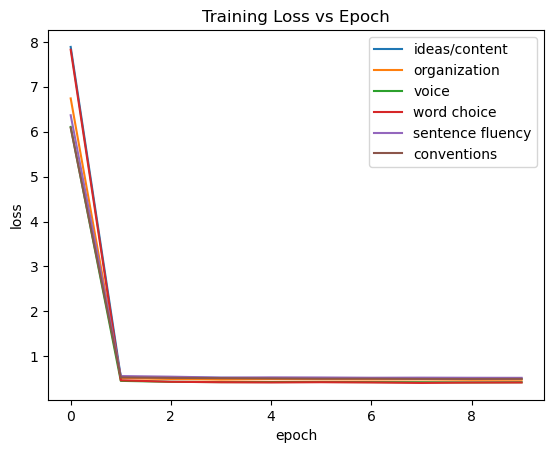

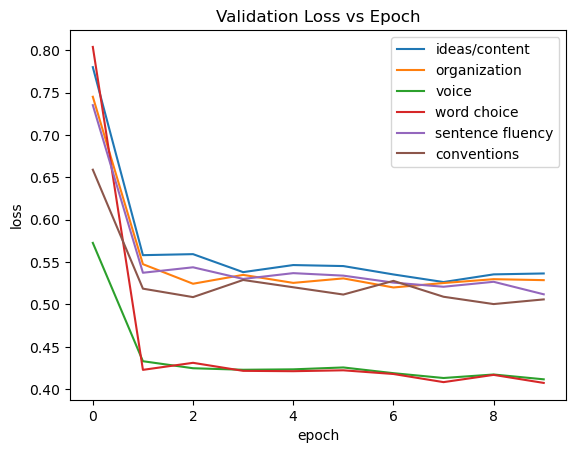

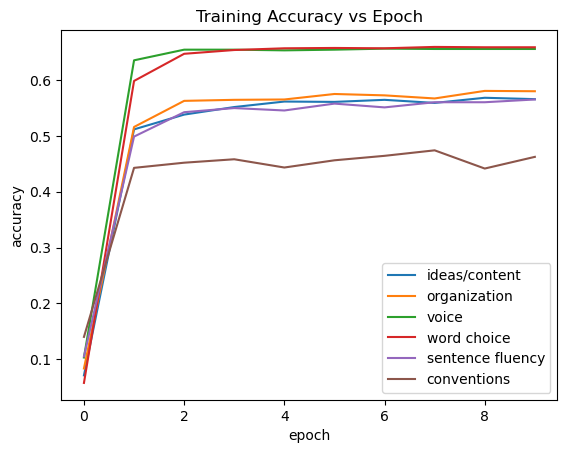

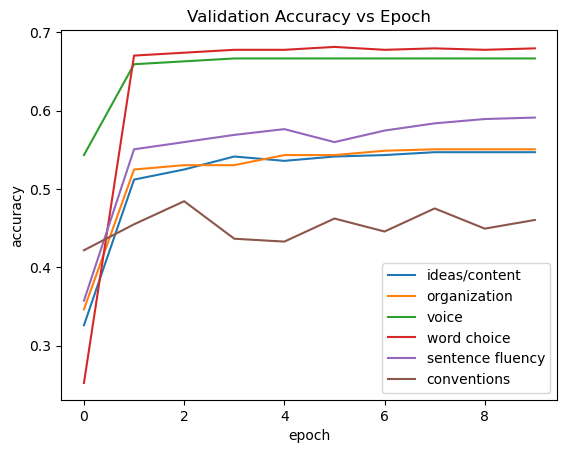

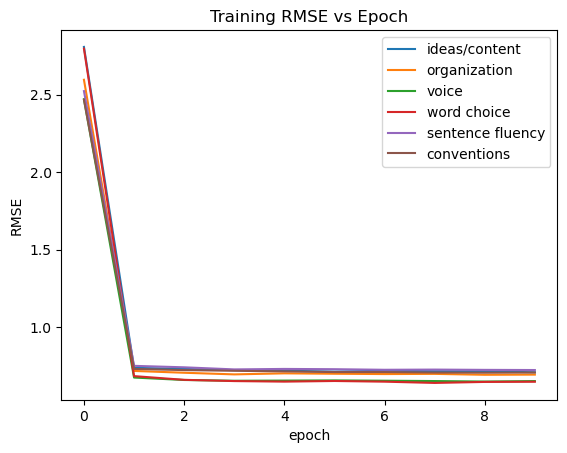

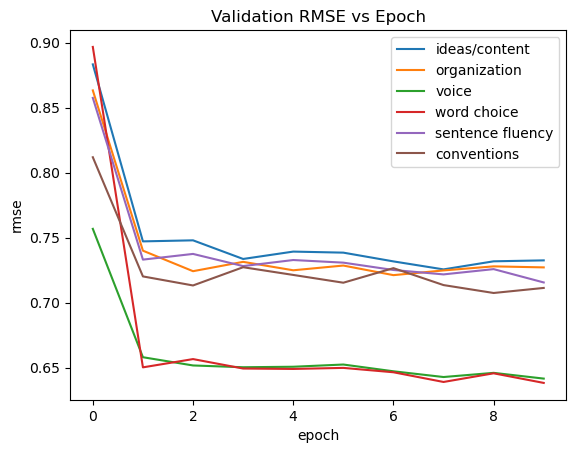

In [13]:
for index in range(6):
    plt.plot(trn_loss_list[index], label=str(index_to_cat[index]))
plt.title("Training Loss vs Epoch")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

for index in range(6):
    plt.plot(val_loss_list[index], label=str(index_to_cat[index]))
plt.title("Validation Loss vs Epoch")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

for index in range(6):
    plt.plot(trn_acc_list[index], label=str(index_to_cat[index]))
plt.title("Training Accuracy vs Epoch")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

for index in range(6):
    plt.plot(val_acc_list[index], label=str(index_to_cat[index]))
plt.title("Validation Accuracy vs Epoch")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

for index in range(6):
    plt.plot(trn_rmse_list[index], label=str(index_to_cat[index]))
plt.title("Training RMSE vs Epoch")
plt.xlabel("epoch")
plt.ylabel("RMSE")
plt.legend()
plt.show()

for index in range(6):
    plt.plot(val_rmse_list[index], label=str(index_to_cat[index]))
plt.title("Validation RMSE vs Epoch")
plt.xlabel("epoch")
plt.ylabel("rmse")
plt.legend()
plt.show()


In [14]:
selected_essay_index = 0

data_example = Dataset("testing1.xls")
data_example.preprocess()
data_example.text = [data_example.text[selected_essay_index]]
data_example.essay_id = [data_example.essay_id[selected_essay_index]]
data_example.scores = [data_example.scores[selected_essay_index]]
data_example.create_vocab()
data_example.text_num()
data_example.create_chunks()
train_text_example = data_example.new_data

for i in range(len(train_text_example)):
    while len(train_text_example[i][0])<=max_len:
        train_text_example[i][0].append(0)

In [15]:
for cat in range(6):
    print("Category: ", index_to_cat[cat])
    for chunk in range(3):
        hidden = model_list[cat].make_hidden()
        prediction, hidden = model_list[cat](torch.from_numpy(np.array(train_text_example[chunk])).to(torch.int64).to(device), hidden)
        print("Section:", chunk, " Predicted Score:", prediction.item(), " True Score:", data_example.scores[0][cat])
    print("\n")

Category:  ideas/content
Section: 0  Predicted Score: 3.639566659927368  True Score: 4
Section: 1  Predicted Score: 3.788808584213257  True Score: 4
Section: 2  Predicted Score: 3.8446052074432373  True Score: 4


Category:  organization
Section: 0  Predicted Score: 3.6799042224884033  True Score: 4
Section: 1  Predicted Score: 3.7092039585113525  True Score: 4
Section: 2  Predicted Score: 3.776977062225342  True Score: 4


Category:  voice
Section: 0  Predicted Score: 4.125394344329834  True Score: 4
Section: 1  Predicted Score: 4.003897666931152  True Score: 4
Section: 2  Predicted Score: 3.8169312477111816  True Score: 4


Category:  word choice
Section: 0  Predicted Score: 3.816555976867676  True Score: 4
Section: 1  Predicted Score: 3.936333656311035  True Score: 4
Section: 2  Predicted Score: 3.95072078704834  True Score: 4


Category:  sentence fluency
Section: 0  Predicted Score: 3.7929370403289795  True Score: 4
Section: 1  Predicted Score: 3.6293892860412598  True Score: 4
Se

In [18]:
selected_essay_index = 0

data_example = Dataset("testing2.xls")
data_example.preprocess()
data_example.text = [data_example.text[selected_essay_index]]
data_example.essay_id = [data_example.essay_id[selected_essay_index]]
data_example.scores = [data_example.scores[selected_essay_index]]
data_example.create_vocab()
data_example.text_num()
data_example.create_chunks()
train_text_example = data_example.new_data

for i in range(len(train_text_example)):
    while len(train_text_example[i][0])<=max_len:
        train_text_example[i][0].append(0)

In [19]:
for cat in range(6):
    print("Category: ", index_to_cat[cat])
    for chunk in range(3):
        hidden = model_list[cat].make_hidden()
        prediction, hidden = model_list[cat](torch.from_numpy(np.array(train_text_example[chunk])).to(torch.int64).to(device), hidden)
        print("Section:", chunk, " Predicted Score:", prediction.item(), " True Score:", data_example.scores[0][cat])
    print("\n")

Category:  ideas/content
Section: 0  Predicted Score: 3.80059552192688  True Score: 4
Section: 1  Predicted Score: 3.776930809020996  True Score: 4
Section: 2  Predicted Score: 3.7676541805267334  True Score: 4


Category:  organization
Section: 0  Predicted Score: 3.8892953395843506  True Score: 4
Section: 1  Predicted Score: 3.7514548301696777  True Score: 4
Section: 2  Predicted Score: 3.609849452972412  True Score: 4


Category:  voice
Section: 0  Predicted Score: 3.922327995300293  True Score: 4
Section: 1  Predicted Score: 3.93912935256958  True Score: 4
Section: 2  Predicted Score: 3.9044625759124756  True Score: 4


Category:  word choice
Section: 0  Predicted Score: 3.954939365386963  True Score: 4
Section: 1  Predicted Score: 3.903106451034546  True Score: 4
Section: 2  Predicted Score: 3.968144178390503  True Score: 4


Category:  sentence fluency
Section: 0  Predicted Score: 3.6674227714538574  True Score: 4
Section: 1  Predicted Score: 3.7951180934906006  True Score: 4
Sec